In [ ]:
# dateCrawled: дата, когда объявление впервые было найдено (спарсено); все значения полей взяты с этого дня
# name: "имя" автомобиля (обычно содержит марку и модель)
# seller: продавец — частное лицо (private) или дилер (dealer)
# offerType: тип предложения (например, продажа или аренда; уточнить по данным)
# price: цена, указанная в объявлении
# abtest: участие в A/B-тестировании (используется для анализа поведения пользователей, точное значение зависит от платформы)
# vehicleType: тип транспортного средства (например, легковой, внедорожник, минивэн и т.д.)
# yearOfRegistration: год, когда автомобиль был впервые зарегистрирован
# gearbox: тип коробки передач (например, автоматическая или механическая)
# powerPS: мощность автомобиля в лошадиных силах (PS — немецкое обозначение)
# model: модель автомобиля
# kilometer: пробег автомобиля в километрах
# monthOfRegistration: месяц, когда автомобиль был впервые зарегистрирован
# fuelType: тип топлива (например, бензин, дизель, электричество и т.д.)
# brand: марка автомобиля
# notRepairedDamage: есть ли повреждение, которое до сих пор не отремонтировано
# dateCreated: дата создания объявления на eBay
# nrOfPictures: количество изображений в объявлении (однако это поле всегда содержит 0 из-за ошибки в парсере, поэтому бесполезно)
# postalCode: почтовый индекс местоположения продавца
# lastSeenOnline: дата, когда объявление последний раз было замечено онлайн парсером

#целевая колонка - price

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr

In [3]:
autos = pd.read_csv('autos.csv', encoding='latin1')

In [4]:
#количество строк до удаления дубликатов
autos.shape

(371528, 20)

In [5]:
autos_without_duplicates = autos.drop_duplicates()
autos_without_duplicates.to_csv('autos_without_duplicates.csv', index=False)

In [6]:
#количество строк после удаления дубликатов
autos_without_duplicates.shape

(371524, 20)

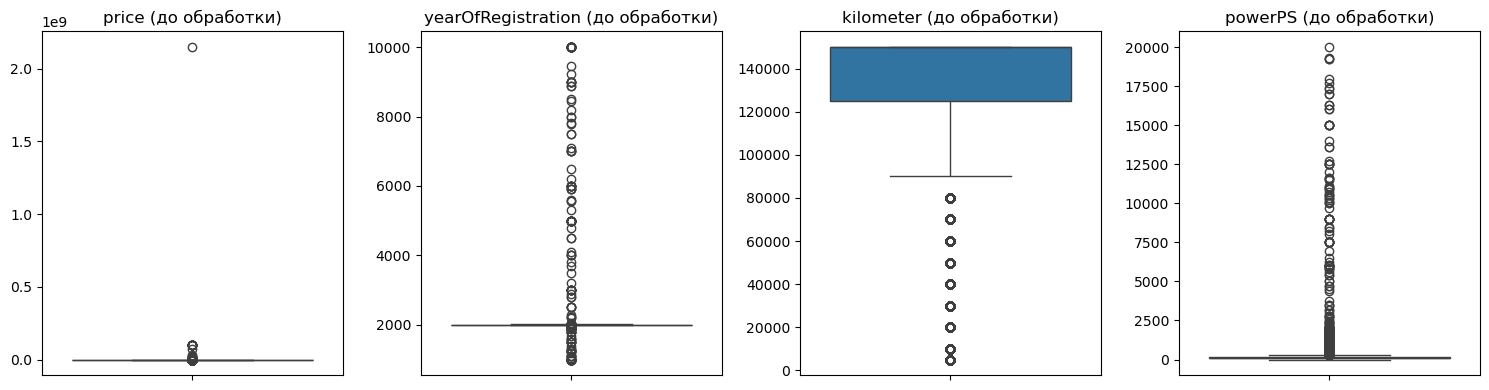

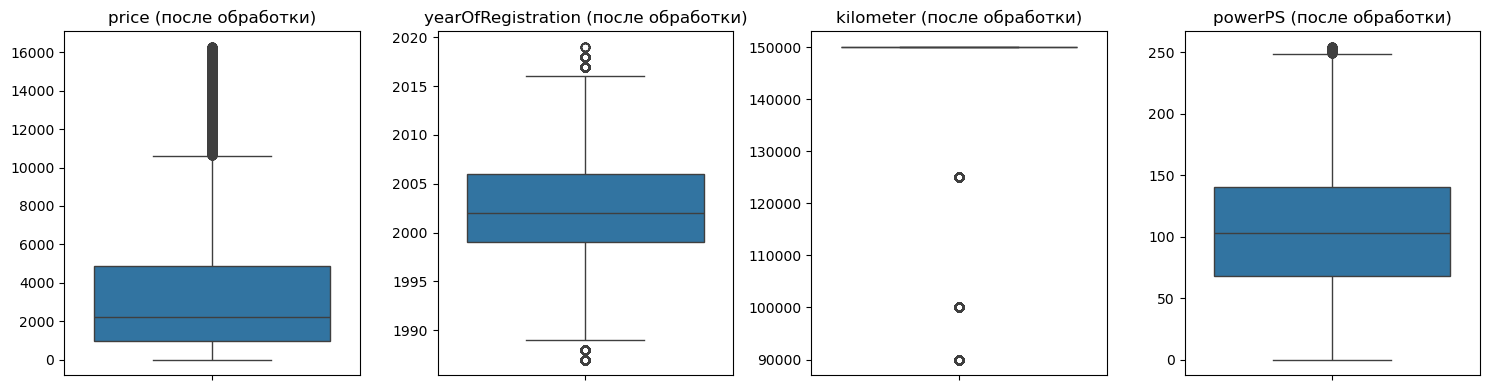


Статистика обработки:
Было записей: 371524
Осталось записей: 286363
Удалено записей: 85161


In [7]:
autos = pd.read_csv('autos_without_duplicates.csv')

#функция для удаления выбросов
def remove_outliers(df, column, iqr_coef=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_coef * IQR
    upper_bound = Q3 + iqr_coef * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

#выбираем нужные столбцы
columns_to_check = ['price', 'yearOfRegistration', 'kilometer', 'powerPS']

#создаем фигуру для графиков до обработки
plt.figure(figsize=(15, 4))  

#Boxplot для каждого столбца до обработки
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(1, len(columns_to_check), i)
    sns.boxplot(y=autos[column])
    plt.title(f'{column} (до обработки)')
    plt.ylabel('')

plt.tight_layout()
plt.show()

#обработка данных
clean_data = autos.copy()
for column in columns_to_check:
    clean_data = remove_outliers(clean_data, column, iqr_coef=1.5)

#создаем фигуру для графиков после обработки
plt.figure(figsize=(15, 4))

#Boxplot для каждого столбца после обработки
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(1, len(columns_to_check), i)
    sns.boxplot(y=clean_data[column])
    plt.title(f'{column} (после обработки)')
    plt.ylabel('')

plt.tight_layout()
plt.show()

#статистика
print(f"\nСтатистика обработки:")
print(f"Было записей: {len(autos)}")
print(f"Осталось записей: {len(clean_data)}")
print(f"Удалено записей: {len(autos) - len(clean_data)}")

In [8]:
clean_data.to_csv('clean_data.csv', index=False)

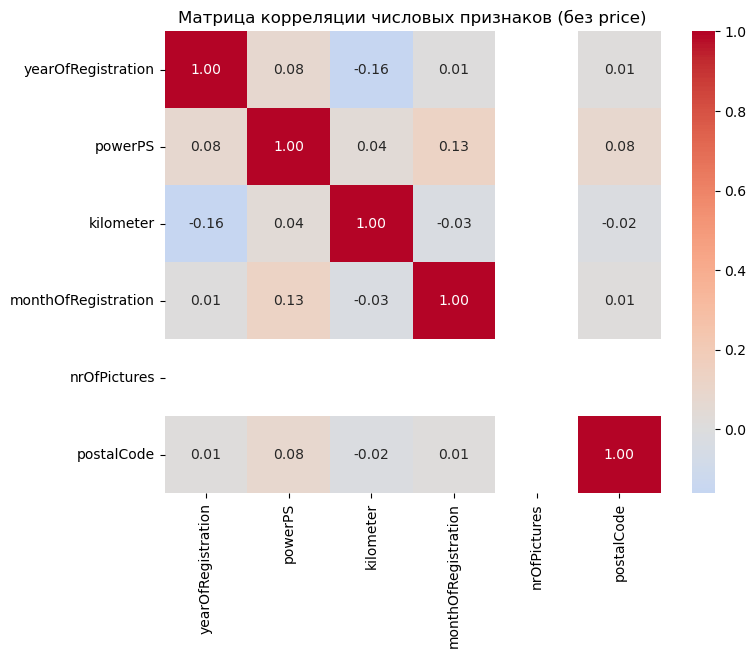

Топ признаков по количеству корреляций (|r| > 0.5):
yearOfRegistration: 0 корреляций
powerPS: 0 корреляций
kilometer: 0 корреляций
monthOfRegistration: 0 корреляций
postalCode: 0 корреляций


In [9]:
data = pd.read_csv('clean_data.csv')

#оставляем только числовые столбцы и исключаем целевой признак 'price'
numeric_data = data.select_dtypes(include=['number']).drop(['price'], axis=1, errors='ignore')

#расчет корреляционной матрицы
corr_matrix = numeric_data.corr()

#визуализация матрицы корреляции
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Матрица корреляции числовых признаков (без price)')
plt.show()

#поиск признаков, которые имеют наибольшее число корреляций выше порога
high_corr_features = {}
threshold = 0.5

for column in corr_matrix.columns:
    high_corr_count = (abs(corr_matrix[column]) > threshold).sum() - 1  # без самого себя
    high_corr_features[column] = high_corr_count

#сортировка по количеству сильных корреляций
sorted_features = sorted(high_corr_features.items(), key=lambda x: x[1], reverse=True)

print("Топ признаков по количеству корреляций (|r| > 0.5):")
for feature, count in sorted_features[:5]:
    print(f"{feature}: {count} корреляций")

In [10]:
clean_data.isnull().sum().sort_values(ascending=False)

notRepairedDamage      59650
vehicleType            30874
fuelType               26469
gearbox                14869
model                  14742
seller                     0
name                       0
dateCrawled                0
offerType                  0
abtest                     0
yearOfRegistration         0
price                      0
kilometer                  0
powerPS                    0
monthOfRegistration        0
brand                      0
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

In [11]:
(clean_data.isnull().mean() * 100).sort_values(ascending=False)

notRepairedDamage      20.830205
vehicleType            10.781421
fuelType                9.243163
gearbox                 5.192361
model                   5.148011
seller                  0.000000
name                    0.000000
dateCrawled             0.000000
offerType               0.000000
abtest                  0.000000
yearOfRegistration      0.000000
price                   0.000000
kilometer               0.000000
powerPS                 0.000000
monthOfRegistration     0.000000
brand                   0.000000
dateCreated             0.000000
nrOfPictures            0.000000
postalCode              0.000000
lastSeen                0.000000
dtype: float64

In [ ]:
#нулевые значения в столбце notRepairedDamage могут возникать из-за того, что у автомобиля нет повреждений,
#а значит нечего чинить в принципе
# нулевые значения в столбцах vehicleType, fuelType, gearbox, model могут возникать из-за того, что возникли ошибки при сборе данных
#или значения не были известны

In [12]:
categorical_columns = ['notRepairedDamage', 'vehicleType', 'fuelType', 'gearbox', 'model']

#заполняем пропуски в категориальных столбцах значением 'Unknown'
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
clean_data[categorical_columns] = categorical_imputer.fit_transform(clean_data[categorical_columns])

#выводим результаты
print("Пропущенные значения заполнены.")
print(clean_data[['notRepairedDamage', 'vehicleType', 'fuelType', 'gearbox', 'model']].isnull().sum())

Пропущенные значения заполнены.
notRepairedDamage    0
vehicleType          0
fuelType             0
gearbox              0
model                0
dtype: int64


In [13]:
clean_data.to_csv('clean_auto.csv', index=False)

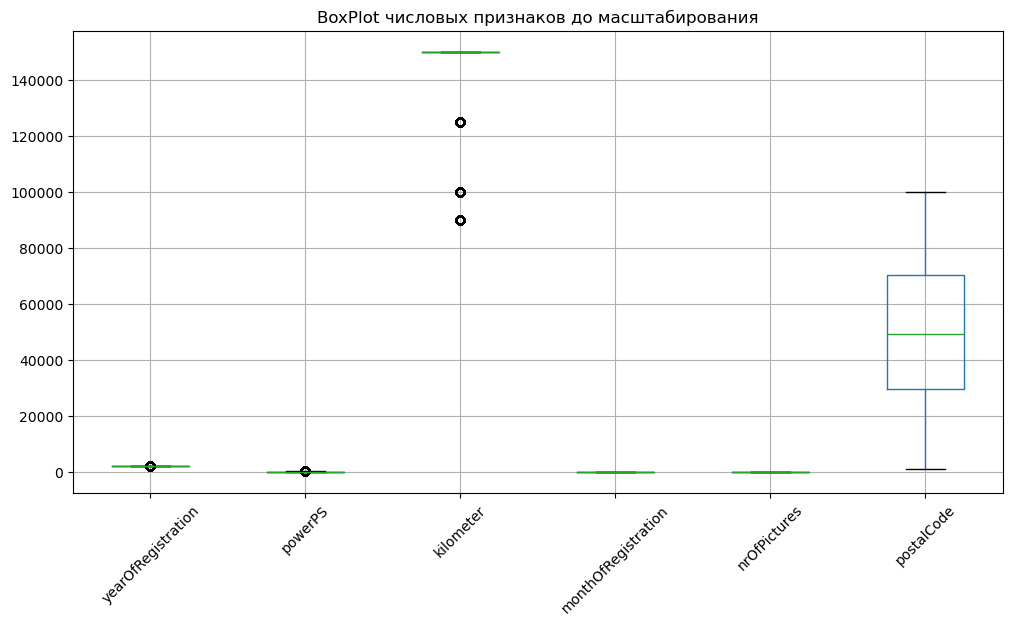

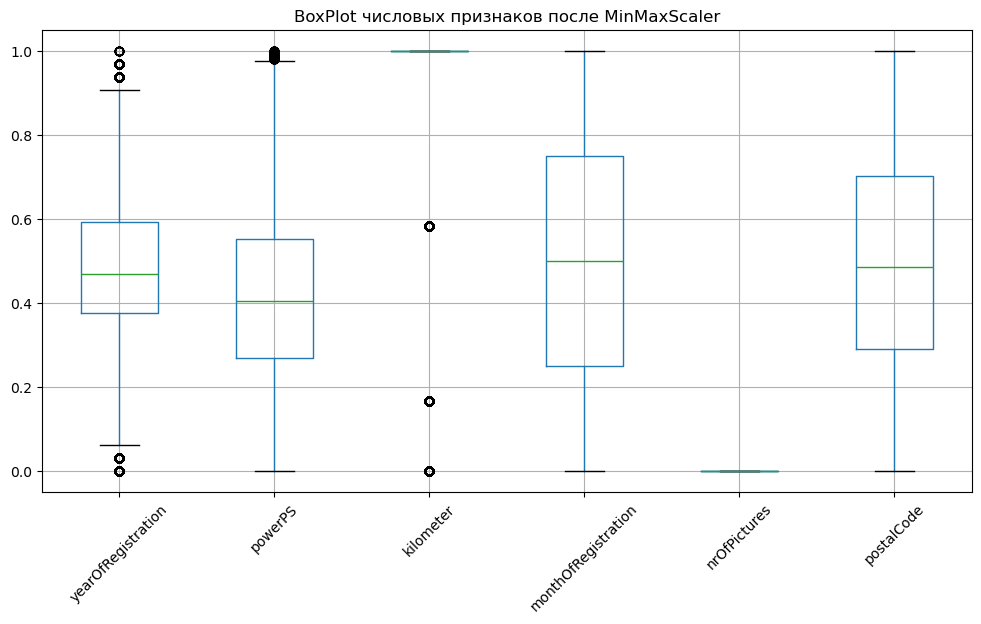

In [14]:
#указываем количественные признаки
numeric_cols = ['yearOfRegistration', 'powerPS', 
                'kilometer', 'monthOfRegistration', 'nrOfPictures', 'postalCode']

#копируем числовые данные
numeric_data = clean_data[numeric_cols].copy()

#BoxPlot до масштабирования 
plt.figure(figsize=(12, 6))
numeric_data.boxplot()
plt.title('BoxPlot числовых признаков до масштабирования')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#способ масштабирования - MinMaxScaler 
scaler = MinMaxScaler()

#выполнение масштабирования
scaled_data = scaler.fit_transform(numeric_data)
scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols)

#BoxPlot после масштабирования
plt.figure(figsize=(12, 6))
scaled_df.boxplot()
plt.title('BoxPlot числовых признаков после MinMaxScaler')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [15]:
clean_data = clean_data.drop(['nrOfPictures', 'dateCrawled', 'lastSeen'], axis=1)                                                                            
clean_data.to_csv('cleaned_autos.csv', index=False)

In [16]:
df = pd.read_csv('cleaned_autos.csv')

#определяем категориальные и числовые столбцы
categorical_cols = ['seller', 'offerType', 'abtest', 'vehicleType', 
                   'gearbox', 'model', 'fuelType', 'brand', 
                   'notRepairedDamage']
numeric_cols = ['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration']

#проверяем существующие столбцы
existing_cat_cols = [col for col in categorical_cols if col in df.columns]
existing_num_cols = [col for col in numeric_cols if col in df.columns]

#создаем преобразователь
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), existing_cat_cols),
        ('num', 'passthrough', existing_num_cols)
    ],
    remainder='drop'
)

#применяем преобразование
encoded_data = preprocessor.fit_transform(df)

#получаем имена всех столбцов
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(existing_cat_cols)
all_features = list(cat_features) + existing_num_cols

df_encoded = pd.DataFrame(encoded_data, columns=all_features)

df_encoded.to_csv('autos_onehot_encoded.csv', index=False)

In [ ]:
#Используем OneHotEncoder, так как он представляет категориальную переменную, содержащую дискретные числовые значения

In [17]:
df = pd.read_csv('autos_onehot_encoded.csv')

# выделяем целевую переменную (price) и признаки
X = df.drop('price', axis=1)
y = df['price']

#разделение на train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#линейная регрессия без регуляризации 
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

#Ridge-регрессия с подбором параметров 
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
ridge = GridSearchCV(Ridge(), 
                    ridge_params, 
                    cv=5,
                    scoring='neg_mean_squared_error',
                    refit=True)  # refit=True - переобучит на всех данных с лучшими параметрами

ridge.fit(X_train_scaled, y_train)

# обоснование выбора метрики:
#выбрана neg_mean_squared_error, так как:
# 1. MSE чувствительна к большим ошибкам 
# 2. Отрицательная, потому что GridSearchCV максимизирует метрику

# Предсказания на тестовых данных
y_pred_lin = lin_reg.predict(X_test_scaled)
y_pred_ridge = ridge.best_estimator_.predict(X_test_scaled)

#оценка качества 
print("Линейная регрессия:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lin):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lin):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin)):.2f}")

print("\nRidge регрессия (alpha={}):".format(ridge.best_params_['alpha']))
print(f"MAE: {mean_absolute_error(y_test, y_pred_ridge):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ridge):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.2f}")

#коэффициенты корреляции 
pearson_lin = pearsonr(y_test, y_pred_lin)
spearman_lin = spearmanr(y_test, y_pred_lin)

print("\nКорреляции для линейной регрессии:")
print(f"Пирсон: r={pearson_lin[0]:.3f}, p-value={pearson_lin[1]:.3f}")
print(f"Спирмен: r={spearman_lin[0]:.3f}, p-value={spearman_lin[1]:.3f}")

pearson_ridge = pearsonr(y_test, y_pred_ridge)
spearman_ridge = spearmanr(y_test, y_pred_ridge)

print("\nКорреляции для Ridge регрессии:")
print(f"Пирсон: r={pearson_ridge[0]:.3f}, p-value={pearson_ridge[1]:.3f}")
print(f"Спирмен: r={spearman_ridge[0]:.3f}, p-value={spearman_ridge[1]:.3f}")

Линейная регрессия:
MAE: 1459.38
MSE: 4160809.19
RMSE: 2039.81

Ridge регрессия (alpha=100):
MAE: 1459.35
MSE: 4160821.90
RMSE: 2039.81

Корреляции для линейной регрессии:
Пирсон: r=0.804, p-value=0.000
Спирмен: r=0.821, p-value=0.000

Корреляции для Ridge регрессии:
Пирсон: r=0.804, p-value=0.000
Спирмен: r=0.821, p-value=0.000


In [ ]:
#обе модели показывают почти одинаковые результаты. Это свидетельствует о том, что регуляризация в данном случае не дает существенных изменений.
#обе модели имеют достаточно большие ошибки.
#Коэффициенты корреляции Пирсона и Спирмена указывают на устойчивую линейную и монотонную зависимость.
#p-value=0.000 подтверждает статистическую значимость корреляций

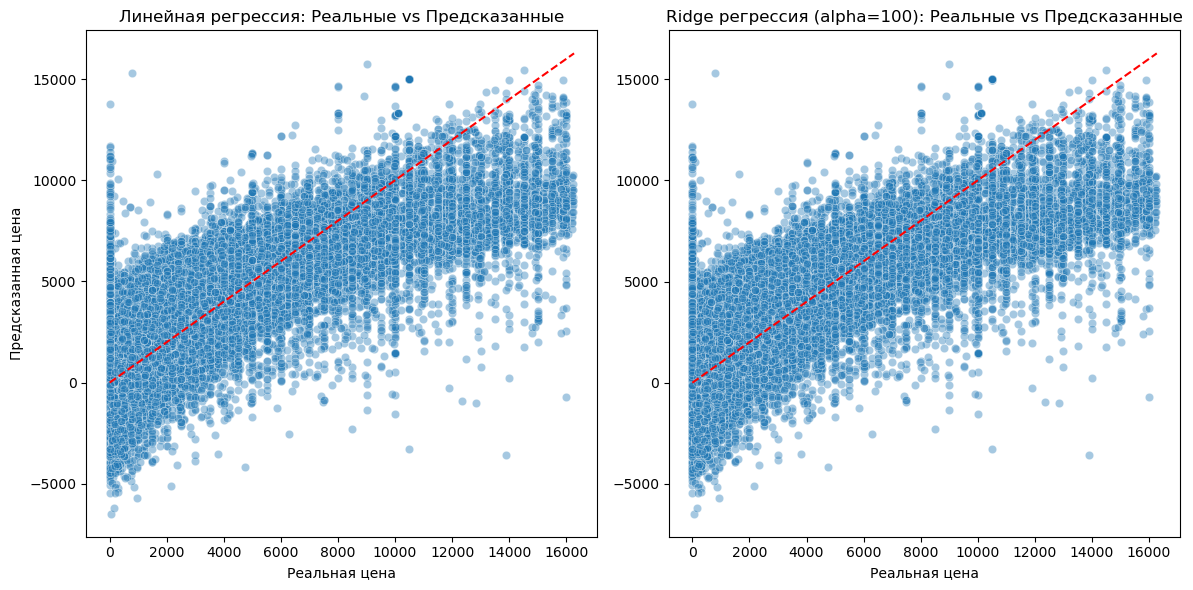

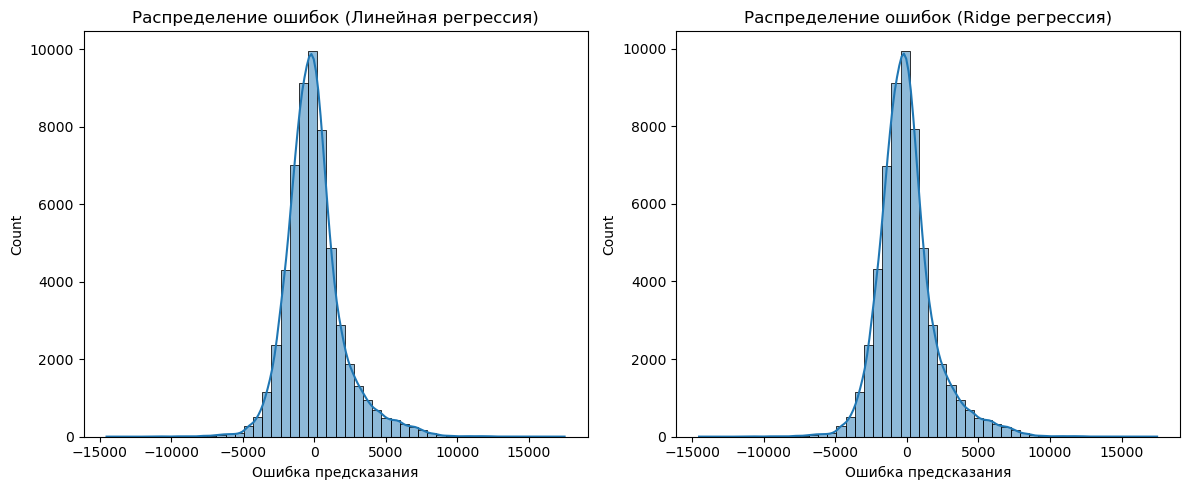

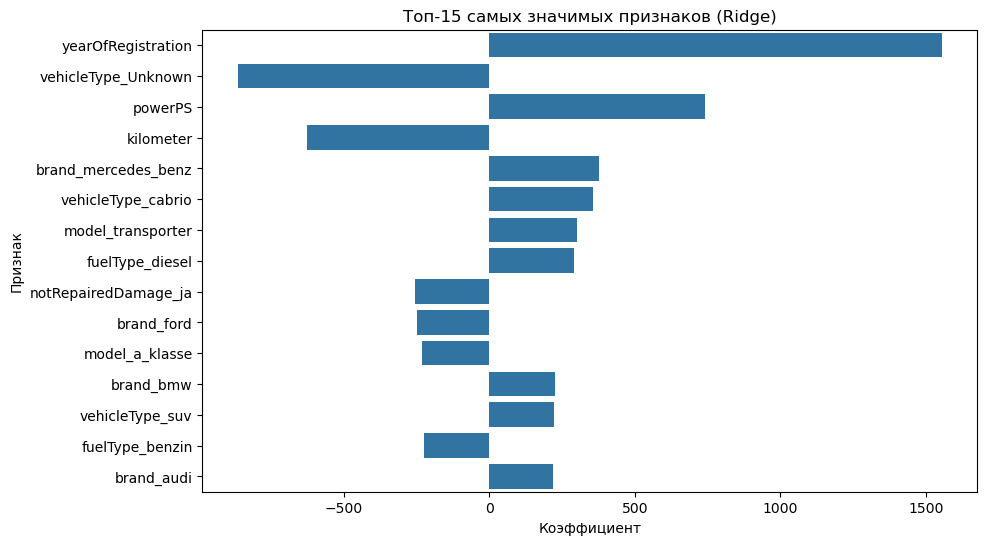

<Figure size 1000x600 with 0 Axes>

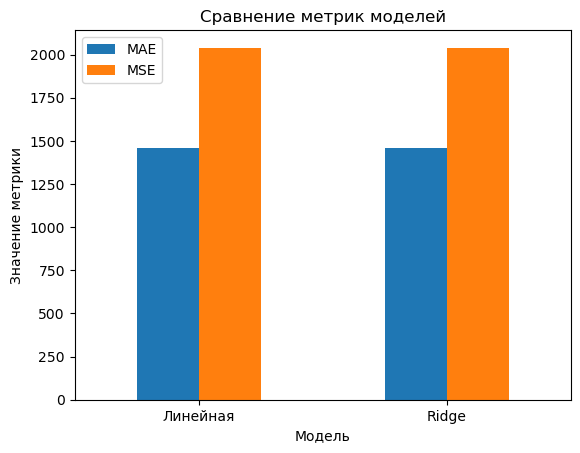

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_lin, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Линейная регрессия: Реальные vs Предсказанные')
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title(f'Ridge регрессия (alpha={ridge.best_params_["alpha"]}): Реальные vs Предсказанные')
plt.xlabel('Реальная цена')

plt.tight_layout()
plt.show()

#распределение ошибок
errors_lin = y_test - y_pred_lin
errors_ridge = y_test - y_pred_ridge

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(errors_lin, bins=50, kde=True)
plt.title('Распределение ошибок (Линейная регрессия)')
plt.xlabel('Ошибка предсказания')

plt.subplot(1, 2, 2)
sns.histplot(errors_ridge, bins=50, kde=True)
plt.title('Распределение ошибок (Ridge регрессия)')
plt.xlabel('Ошибка предсказания')

plt.tight_layout()
plt.show()

#важность признаков (только для Ridge)
top_features = 15
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coef': ridge.best_estimator_.coef_
}).sort_values('coef', key=abs, ascending=False).head(top_features)

plt.figure(figsize=(10, 6))
sns.barplot(x='coef', y='feature', data=coef_df)
plt.title(f'Топ-{top_features} самых значимых признаков (Ridge)')
plt.xlabel('Коэффициент')
plt.ylabel('Признак')
plt.show()

#Сравнение метрик
metrics_df = pd.DataFrame({
    'Модель': ['Линейная', 'Ridge'],
    'MAE': [mean_absolute_error(y_test, y_pred_lin), 
            mean_absolute_error(y_test, y_pred_ridge)],
    'MSE': [np.sqrt(mean_squared_error(y_test, y_pred_lin)),
             np.sqrt(mean_squared_error(y_test, y_pred_ridge))],
})

plt.figure(figsize=(10, 6))
metrics_df.set_index('Модель').plot(kind='bar', rot=0)
plt.title('Сравнение метрик моделей')
plt.ylabel('Значение метрики')
plt.show()